# Notebook to build Normative model

In [171]:
from nfact_id.functions.idp_functions import create_wide_df
import bambi as bmb
import arviz as az
from decouple import config
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import os
os.environ["CPATH"] = "/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1"

## Get component directory

In [172]:
component_dir = os.path.join(config("base_dir"), "component_loadings", "hcp")
storage_dir = os.path.join(config("base_dir"), "group_tests")

## Pre-process data

In [173]:
df_wide = create_wide_df(os.path.join(component_dir, "G_component_loadings.csv"), os.path.join(component_dir, "W_component_loadings.csv"))
participant_info = pd.read_csv(os.path.join(component_dir, "participants_dr.csv"))
df_wide['group'] = participant_info['phenotype']

In [178]:
control_wide = df_wide[df_wide['group'].str.contains("Control")].reset_index(drop=True)
control_hold_out = control_wide.sample(frac=0.25, replace=False, random_state=1).reset_index(drop=True)

### Create long df

In [181]:
long_df = pd.melt(df_wide, id_vars=['subject', 'group'], var_name='component', value_name='value')
long_df['component_num'] = long_df['component'].str.extract(r'(\d+)').astype(int)
long_df = long_df.sort_values(by=['subject', 'component_num'])
long_df['comp_type'] = long_df['component'].apply(lambda x: 'Grey' if 'G_' in x else 'White')
long_df = long_df.drop(columns='component').reset_index(drop=True)
long_df.loc[long_df['subject'].isin(control_hold_out['subject'].values), 'group'] = "HC"

## Get controls

In [182]:
controls = long_df[long_df['group'].str.contains("Control")].reset_index(drop=True)
controls_grey = controls[controls['comp_type'].str.contains("Grey")]
controls_white = controls[controls['comp_type'].str.contains("White")]

## The models

In [186]:
model_ctrl_white = bmb.Model(
   "value ~ 0 + component_num + (1 | subject)",
    data=controls_white,
    family="beta",
    categorical=['subject', 'component_num'],
    priors={
        "component_num": bmb.Prior("Normal", mu=0, sigma=1), # More informative sigma
        "1|subject": bmb.Prior("Normal", mu=0.0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    }

)

In [187]:
model_ctrl_grey = bmb.Model(
    "value ~ 0 + component_num + (1 | subject)",
    data=controls_grey,
    family="beta",
    categorical=['subject', 'component_num'],
    priors={
        "component_num": bmb.Prior("Normal", mu=0, sigma=1), # More informative sigma
        "1|subject": bmb.Prior("Normal", mu=0.0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    }
)

### View priors

In [188]:
model_ctrl_white

       Formula: value ~ 0 + component_num + (1 | subject)
        Family: beta
          Link: mu = logit
  Observations: 12200
        Priors: 
    target = mu
        Common-level effects
            component_num ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
        
        Auxiliary parameters
            kappa ~ HalfCauchy(beta: 1.0)

In [189]:
model_ctrl_grey

       Formula: value ~ 0 + component_num + (1 | subject)
        Family: beta
          Link: mu = logit
  Observations: 12200
        Priors: 
    target = mu
        Common-level effects
            component_num ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
        
        Auxiliary parameters
            kappa ~ HalfCauchy(beta: 1.0)

## Build the models

In [190]:
idata_ctrl_white = model_ctrl_white.fit(tune=3000, draw=3000, cores=4, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_kappa, component_num, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 553 seconds.


In [191]:
idata_ctrl_grey = model_ctrl_grey.fit(tune=3000, draw=3000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_kappa, component_num, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 563 seconds.


## Explore normative models

In [192]:
az.summary(idata_ctrl_white)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
component_num[0],0.753,0.030,0.696,0.808,0.001,0.001,3030.0,2573.0,1.0
component_num[1],1.107,0.032,1.048,1.168,0.001,0.001,3239.0,2460.0,1.0
component_num[2],1.124,0.033,1.059,1.185,0.001,0.001,3510.0,2360.0,1.0
component_num[3],0.306,0.029,0.251,0.360,0.001,0.000,3030.0,2954.0,1.0
component_num[4],1.009,0.034,0.943,1.069,0.001,0.001,3875.0,2416.0,1.0
...,...,...,...,...,...,...,...,...,...
1|subject[s0021],0.035,0.032,-0.029,0.092,0.001,0.001,3273.0,3248.0,1.0
1|subject[s0023],0.060,0.033,-0.002,0.123,0.001,0.001,3490.0,2588.0,1.0
1|subject[s0024],0.011,0.034,-0.054,0.074,0.001,0.001,3695.0,2699.0,1.0
1|subject[s0027],-0.000,0.034,-0.060,0.065,0.001,0.001,3349.0,2597.0,1.0


In [193]:
az.summary(idata_ctrl_grey)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
component_num[0],0.005,0.023,-0.037,0.050,0.000,0.000,2626.0,2394.0,1.0
component_num[1],1.387,0.029,1.329,1.438,0.001,0.001,3102.0,2792.0,1.0
component_num[2],1.028,0.027,0.978,1.077,0.000,0.001,3260.0,2605.0,1.0
component_num[3],-0.224,0.023,-0.266,-0.180,0.000,0.000,2771.0,2641.0,1.0
component_num[4],1.546,0.030,1.491,1.605,0.000,0.001,3966.0,2230.0,1.0
...,...,...,...,...,...,...,...,...,...
1|subject[s0021],0.021,0.027,-0.033,0.071,0.000,0.000,4521.0,2825.0,1.0
1|subject[s0023],-0.025,0.027,-0.074,0.028,0.000,0.000,3266.0,2741.0,1.0
1|subject[s0024],-0.035,0.027,-0.086,0.013,0.000,0.000,3437.0,2921.0,1.0
1|subject[s0027],-0.061,0.027,-0.112,-0.010,0.000,0.000,3242.0,2486.0,1.0


### plot traces

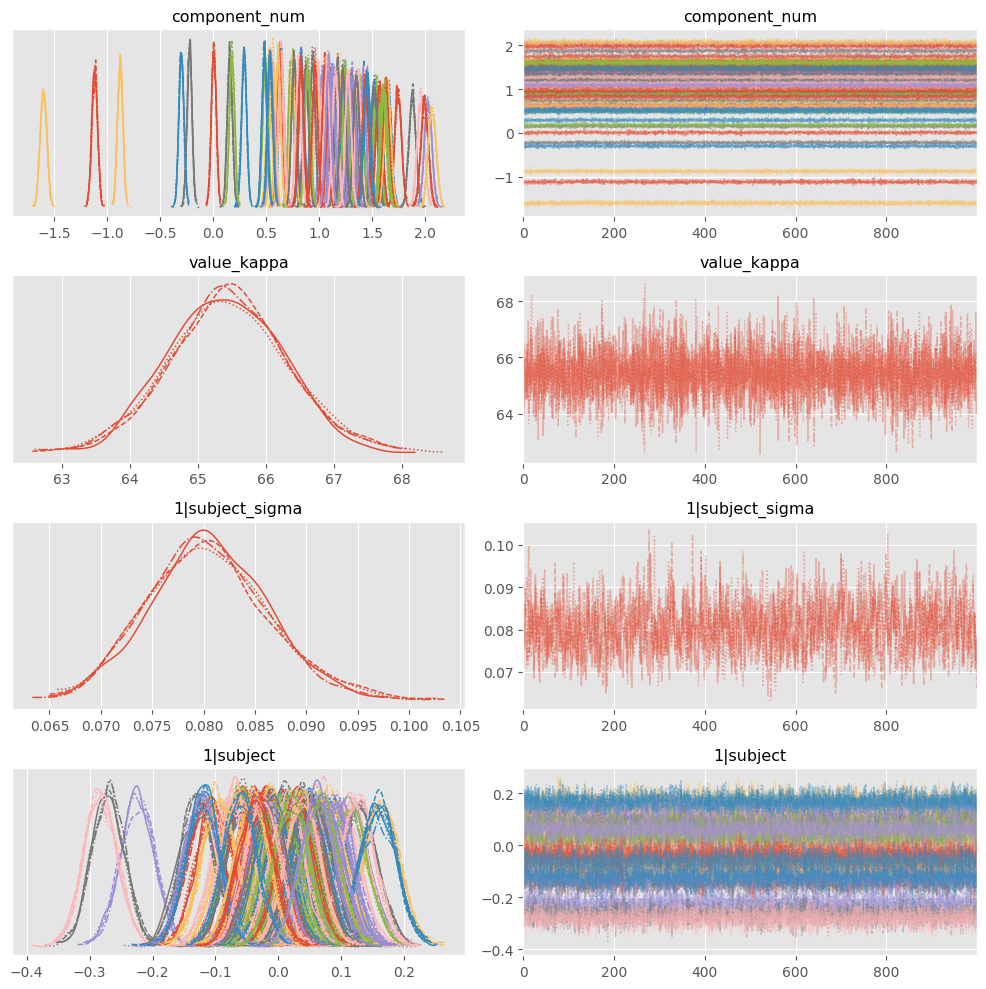

In [194]:
az.plot_trace(idata_ctrl_grey, figsize=(10,10))
plt.tight_layout()

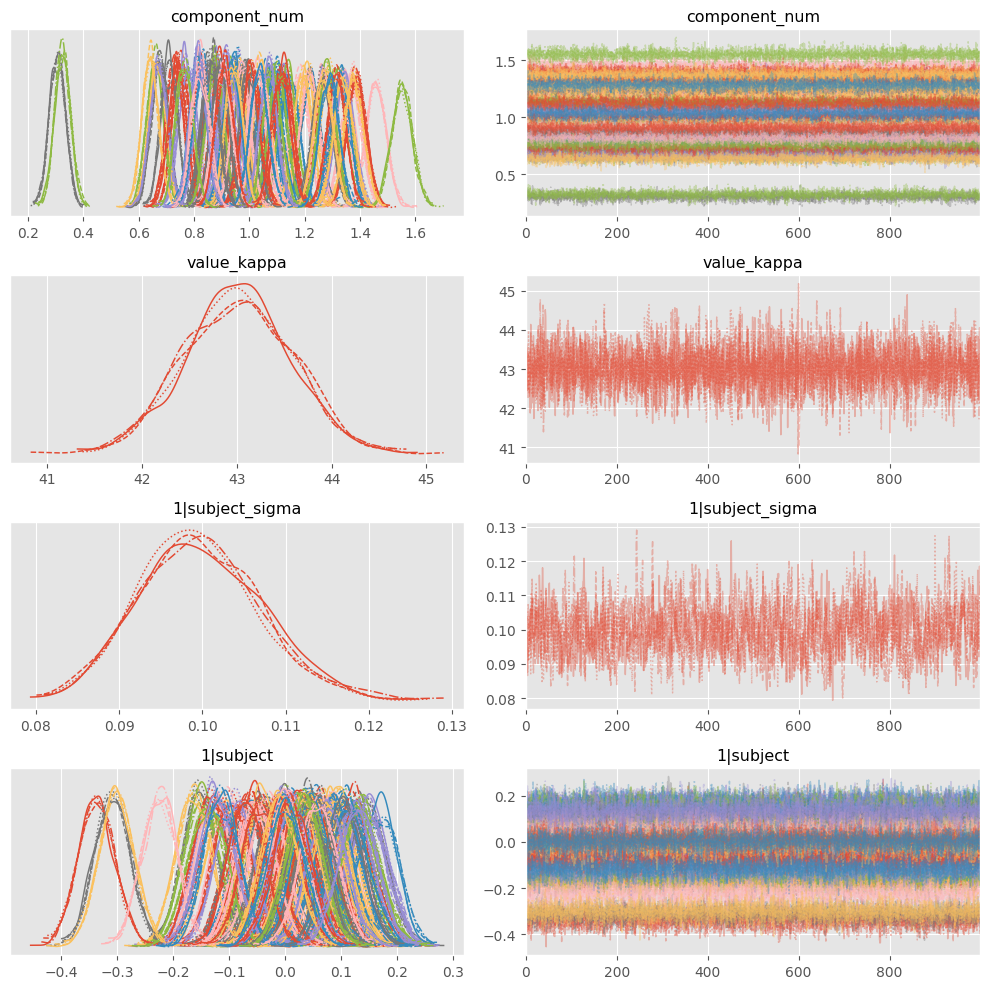

In [195]:
az.plot_trace(idata_ctrl_white, figsize=(10,10))
plt.tight_layout()

## Fit posterior predict

### Get Patient Data

In [215]:
patients = long_df[~long_df['group'].str.contains("Control")]
grey_ppc_df =  patients[patients['comp_type'].str.contains("Grey")]
white_ppc_df = patients[patients['comp_type'].str.contains("White")]

### Calculate PPC

In [216]:
model_ctrl_white.predict(idata=idata_ctrl_white, data=white_ppc_df, kind="pps", sample_new_groups=True)
model_ctrl_grey.predict(idata=idata_ctrl_grey, data=grey_ppc_df, kind="pps", sample_new_groups=True)

### Plot PPC 

<Axes: xlabel='value'>

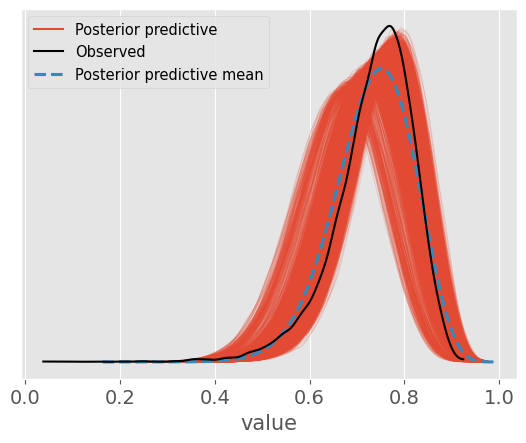

In [217]:
az.plot_ppc(idata_ctrl_white)

<Axes: xlabel='value'>

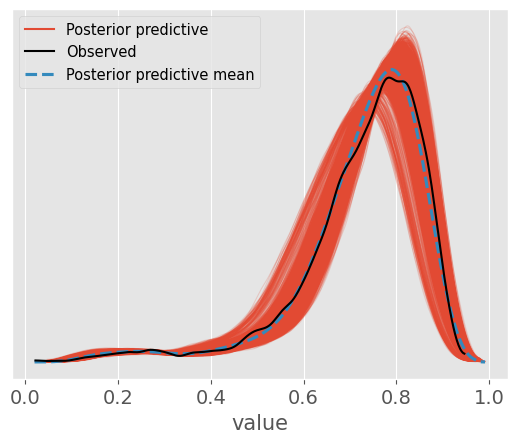

In [218]:
az.plot_ppc(idata_ctrl_grey)

## Save Models

In [219]:
idata_ctrl_white.to_netcdf(os.path.join(storage_dir, "normative_WM_fitted.nc"))
idata_ctrl_grey.to_netcdf(os.path.join(storage_dir, "normative_GM_fitted.nc"))

'/Users/mszdjh3/data/nfact_mh/group_tests/normative_GM_fitted.nc'

In [221]:
white_ppc_df.to_csv(os.path.join(storage_dir, "white_ppc.csv"), index=False)
grey_ppc_df.to_csv(os.path.join(storage_dir, "grey_ppc.csv"), index=False)